In [1]:
#basic tools
import numpy as np
import math
import scipy.optimize as minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
cf.go_offline()
%matplotlib inline

#Decision tree tools
from sklearn.tree import DecisionTreeClassifier,export_graphviz,export_text,plot_tree
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import train_test_split,ShuffleSplit,GridSearchCV,RandomizedSearchCV
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn import set_config
set_config('diagram')

#evaluation tools
from sklearn.metrics import accuracy_score,precision_score,recall_score, roc_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay


In [2]:
drug_df=pd.read_csv('drug200.csv')

In [3]:
drug_df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
drug_df.shape

(200, 6)

In [5]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [6]:
drug_df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [7]:
drug_df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [8]:
columns=[]
for i in drug_df.columns:
    columns.append(drug_df[i].nunique())

print(columns)

[57, 2, 3, 2, 198, 5]


In [9]:
pd.DataFrame({'value_list':columns},index=drug_df.columns)    

,value_list
Age,57
Sex,2
BP,3
Cholesterol,2
Na_to_K,198
Drug,5


In [10]:
drug_df['Sex'].unique()   #use a onehotencoder

array(['F', 'M'], dtype=object)

In [11]:
drug_df['BP'].unique()   # ordinalecoder [[LOW=0,NORMAL=1,HIGH=2]]

array(['HIGH', 'LOW', 'NORMAL'], dtype=object)

In [12]:
drug_df['Cholesterol'].unique()  ## ordinalecoder [[NORMAL=0,HIGH=1]]

array(['HIGH', 'NORMAL'], dtype=object)

In [13]:
drug_df['Drug'].unique()

array(['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object)

# Prepare the data

In [14]:
X=drug_df.drop('Drug',axis=1)
y=drug_df['Drug']

In [15]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Make a transformer

In [73]:
num_tran=Pipeline(
        steps=[('knnimputer', KNNImputer()),
               ('scaler',StandardScaler())])
cat_tran=Pipeline(
       steps=[('simpleimputer',SimpleImputer(strategy='constant',fill_value='missing')),
              ('onehotencoder',OneHotEncoder(drop='if_binary', sparse=False)),
              ('ordinalencoder',OrdinalEncoder( categories=[['LOW','NORMAL','HIGH']]))])

In [74]:
preprocessor=ColumnTransformer(transformers=[('num',num_tran,make_column_selector(dtype_include=np.number)),
                                             ('cat_1',cat_tran,make_column_selector(dtype_include='object'))])

In [65]:
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['Sex']),
                                     (OrdinalEncoder(categories = [['LOW', 'NORMAL', 'HIGH']]), ['BP']),
                                      (OrdinalEncoder(categories=[[ 'NORMAL','HIGH']]),['Cholesterol']),
                                      remainder=StandardScaler())

In [79]:
#create the pipe
pipe=Pipeline(
          steps=[('transformer',transformer),
                 ('model',DecisionTreeClassifier())])

In [80]:
#create the hyperparamers dictionary
params = {'model__max_depth':[2,4,6],
         'model__min_samples_split':[0.1, 0.2, 0.05],
          'model__criterion': ['gini','entropy'],
          'model__min_samples_leaf':[1,2,3]
         }

### GridSearchCV

In [81]:
grid_pipe=GridSearchCV(estimator=pipe,
                      param_grid=params,
                      cv=5,
                      verbose=1)

In [82]:
grid_pipe.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Sex']),
                                                                        ('ordinalencoder-1',
                                                                         OrdinalEncoder(categories=[['LOW',
                                                                                                     'NORMAL',
                                                                                                     'HIGH']]),
                                                                         ['BP']),
                                                       

In [71]:
grid_pipe.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 4,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 0.1}

In [30]:
grid_pipe.cv_results_

{'mean_fit_time': array([0.01463876, 0.01460767, 0.0137569 , 0.01254115, 0.01395521,
        0.01468654, 0.01335711, 0.01255903, 0.01335526, 0.01236091,
        0.01554112, 0.01395526, 0.013343  , 0.01494679, 0.01375189,
        0.0135705 , 0.01336145, 0.01353455, 0.01532869, 0.01396127,
        0.01322017, 0.012572  , 0.01473112, 0.01346421, 0.01360326,
        0.01487942, 0.01569986, 0.0133215 , 0.0157042 , 0.01213489,
        0.01631103, 0.01371832, 0.01413078, 0.01375499, 0.01552668,
        0.01437912, 0.01527877, 0.01335516, 0.01376171, 0.01477942,
        0.01483688, 0.01521072, 0.01558723, 0.01440506, 0.0140954 ,
        0.01355591, 0.01475234, 0.01398263, 0.01076732, 0.01492748,
        0.01461344, 0.01584339, 0.01483812, 0.01547952]),
 'std_fit_time': array([1.95114300e-03, 2.29521236e-03, 9.71151199e-04, 2.82864572e-03,
        6.14361702e-07, 2.21901793e-03, 4.88363768e-04, 2.40707694e-03,
        4.90082203e-04, 2.71807822e-03, 2.68504993e-03, 6.29028184e-04,
        4.721

In [72]:
grid_pipe.best_score_

0.9928571428571429

In [32]:
grid_pipe.classes_

array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

In [34]:
grid_pipe.best_estimator_['transformer']

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['Sex', 'Cholesterol']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['LOW', 'NORMAL',
                                                             'HIGH']]),
                                 ['BP'])])

In [35]:
grid_pipe.best_estimator_['model']

DecisionTreeClassifier(max_depth=4, min_samples_split=0.1)

In [36]:
grid_pipe.verbose

1

In [37]:
y_preds=grid_pipe.predict(X_test)

In [38]:
confusion=confusion_matrix(y_preds,y_test)
print(confusion)
print(classification_report(y_preds,y_test))

[[26  0  0  0  0]
 [ 0  7  0  0  0]
 [ 0  0  3  0  0]
 [ 0  0  0  6  0]
 [ 0  0  0  0 18]]
              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        26
       drugA       1.00      1.00      1.00         7
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         6
       drugX       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



<AxesSubplot:>

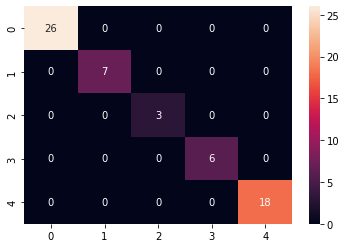

In [39]:
sns.heatmap(confusion, annot=True)

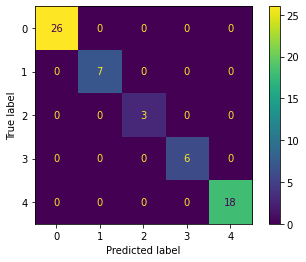

In [40]:
disp=ConfusionMatrixDisplay(confusion)
disp.plot()
plt.show()

### RandomizedSearchCV

In [42]:
ran_pipe=RandomizedSearchCV(estimator=pipe,
                           param_distributions=params,
                           cv=5)

In [43]:
ran_pipe.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='if_binary'),
                                                                               ['Sex',
                                                                                'Cholesterol']),
                                                                              ('ordinalencoder',
                                                                               OrdinalEncoder(categories=[['LOW',
                                                                                                           'NORMAL',
                                                                                                      

In [44]:
ran_pipe.best_params_

{'model__min_samples_split': 0.05,
 'model__min_samples_leaf': 2,
 'model__max_depth': 4,
 'model__criterion': 'entropy'}

In [45]:
ran_pipe.best_estimator_['transformer']

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['Sex', 'Cholesterol']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['LOW', 'NORMAL',
                                                             'HIGH']]),
                                 ['BP'])])

In [46]:
ran_pipe.best_estimator_['model']

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2,
                       min_samples_split=0.05)

In [54]:
ran_pipe.best_score_

0.9928571428571429

In [55]:
ran_pipe.classes_

array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

In [56]:
ran_y_preds=ran_pipe.predict(X_test)

In [57]:
confusioin_ran=confusion_matrix(y_test,ran_y_preds)

In [58]:
print(confusioin_ran)
print(classification_report(y_test,ran_y_preds))

[[26  0  0  0  0]
 [ 0  7  0  0  0]
 [ 0  0  3  0  0]
 [ 0  0  0  6  0]
 [ 0  0  0  0 18]]
              precision    recall  f1-score   support

       DrugY       1.00      1.00      1.00        26
       drugA       1.00      1.00      1.00         7
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         6
       drugX       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



<AxesSubplot:>

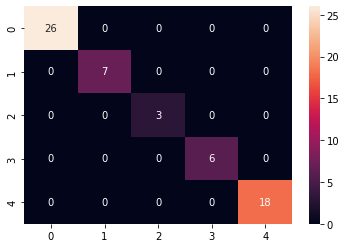

In [59]:
sns.heatmap(confusioin_ran,annot=True)

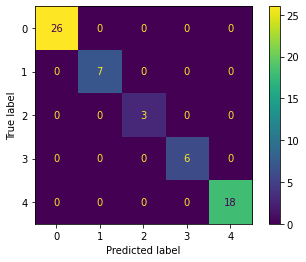

In [60]:
disp_ran=ConfusionMatrixDisplay(confusioin_ran)
disp_ran.plot()
plt.show()